# Abstract:
Este proyecto de Data Science se sumerge en el vasto y dinámico mundo de Beatport, una prominente plataforma de música electrónica, utilizando su rica base de datos de tracks. A través de un análisis exploratorio, el estudio busca descubrir patrones, tendencias y posibles anomalías dentro de los datos, proporcionando insights valiosos tanto para entusiastas de la música como para profesionales de la industria. La hipótesis central gira en torno a la influencia de géneros, subgéneros, duración y bpm (beats por minuto) en la popularidad y distribución de los tracks en Beatport. Este trabajo no solo aspira a ofrecer una perspectiva cuantitativa de la música electrónica y sus comunidades, sino también a enriquecer la comprensión de cómo los atributos técnicos y meta-información de los tracks contribuyen a su éxito y recepción en el mercado.

# Introducción:
Beatport se ha consolidado como una plataforma clave para la distribución de música electrónica, ofreciendo un extenso catálogo que abarca desde lanzamientos mainstream hasta joyas underground. Este proyecto se propone explorar la base de datos de Beatport, centrándose en las características esenciales de los tracks como el género, subgénero, duración, bpm, y más. Al desglosar estos elementos, pretendemos desentrañar cómo se configura el paisaje musical dentro de la plataforma y qué factores contribuyen al éxito de un track.

# Temática:
El estudio se enfoca en la música electrónica, un género caracterizado por su diversidad y constante evolución. Al analizar los datos de Beatport, se pone especial atención en cómo los diferentes géneros y subgéneros musicales se distribuyen y evolucionan con el tiempo, la relación entre las características técnicas de los tracks y su popularidad, y cómo estos aspectos influyen en la dinámica de la plataforma.

# Objetivos:
1. Identificar las tendencias predominantes en géneros y subgéneros dentro de Beatport, observando su evolución a lo largo del tiempo.
2. Analizar la relación entre las características técnicas de los tracks (como bpm y duración) y su popularidad, para entender qué atributos favorecen una mayor recepción entre la audiencia de Beatport.
3. Detectar patrones y anomalías en la distribución y características de los tracks, lo que podría indicar cambios en las preferencias musicales o en la plataforma misma.
4. Ofrecer insights valiosos a productores, DJs, y aficionados de la música electrónica, ayudándoles a comprender mejor el mercado y a optimizar su presencia en Beatport.

Con este proyecto, se busca brindar una perspectiva accesible y comprensible sobre la complejidad de la música electrónica en Beatport, sin requerir que los lectores tengan un conocimiento previo avanzado sobre el tema, pero ofreciendo a la vez profundidad y valor analítico para aquellos más familiarizados con la industria.

In [37]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno

# Lectura de Datos

## Metadata


### bp_track
About this file
- isrc is potentially the single most important column in the entire database. The isrc (International Standard Recording Code) is used to find exact matches through Spotify API and ultimately link this Beatport Database to the MusicBrainz and Discogs databases.

PRIMARY KEY: track_id

FOREIGN KEY:

1. genre_id references bp_genre
2. (genre_id, subgenre_id) references bp_subgenre
3. key_id references bp_key
4. release_id references bp_release
5. label_id references bp_label

ADDITIONAL INFO:

- the significant decrease in count of track_id between 2 - 4 M should not be concerning. The majority of those tracks have either been permanently removed or hidden from view on Beatport.
- bool value in is_remixed does not necessarily indicate whether or not a track is remixed as there are many instances of a track being remixed with no remixers listed on Beatport. It more so references that a remixer was listed on the track i.e. the column is_remixer in table bp_artist_track will be set to True.
- release_date can vary between tracks with the same release_id. This indicates an album/release where tracks came out in different phases, i.e. track being released as a single prior to the final album release date.
- bpm column must be taken with a grain of salt. bpm can be difficult to gauge for a song where it varies wildly. Another consideration is that some genres are more prone to having their bpm listed in either double-time or halftime which will either appear as twice or half of the standard bpm respectively.
- some instances where the duration column represented as a string in HH:MM:SS format is invalid, i.e. minutes or seconds will exceed '59'. These values have been left unmodified.
- catalog seems to be some sort of internal cataloging system between record labels and Beatport. I have found no clear indication that the same catalog numbers are used elsewhere.
- label_track_id is largely irrelevant considering it is used only 60% of the time. Might consider dropping in future updates. It appears to be something that is optionally set up between Beatport and a label for the label to be able to id their own tracks on Beatport.
- is_matched_spot column is a Boolean flag that indicates whether or not I have found a positive id between a Spotify and Beatport. Updates to this column will be coming soon as well as an entire database of Spotify values including audio features.
- updated_on column is in PST

### bp_genre
About this file

PRIMARY KEY: genre_id

ADDITIONAL INFO:
- updated_on column is in PST
- genre_id referenced by tables bp_track & bp_subgenre
- song_count reflects the current song count per genre as of updated_on as indicated from Beatport.com . It is not exactly representative of the number of songs in the database. If you were to view the change in song_count over time, you might notice a net decrease when in reality there would be a net increase. This is due in part to songs being removed from Beatport, 
- release_date getting changed, songs being hidden from view, or the genre being changed.


In [38]:
df_bp_genre = pd.read_csv('./data/bp_genre.csv')
df_bp_track = pd.read_csv('./data/bp_track.csv')
# df_bp_label_artist = pd.read_csv('./data/bp_label_artist.csv')
# df_bp_artist = pd.read_csv('./data/bp_artist.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_20468\529957265.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bp_track = pd.read_csv('./data/bp_track.csv')


In [39]:
df_bp_genre.sort_values('song_count', ascending = False)
df_bp_genre.head()

genre_id                            genre_name  song_count  \
0         8                 Hard Dance / Hardcore      178646   
1        50                      Nu Disco / Disco      157934   
2        12                            Deep House      897280   
3        85                           Bass / Club       20716   
4        94  Electro (Classic / Detroit / Modern)       19615   

                                  genre_url           updated_on  
0              /genre/hard-dance-hardcore/8  2023-09-19 15:01:03  
1                  /genre/nu-disco-disco/50  2023-09-19 15:01:03  
2                      /genre/deep-house/12  2023-09-19 15:01:03  
3                       /genre/bass-club/85  2023-09-19 15:01:03  
4  /genre/electro-classic-detroit-modern/94  2023-09-19 15:01:03

In [40]:
df_bp_track.head()

track_id                     title           mix is_remixed release_date  \
0  17775434            Navigator 3000  Original Mix          f   2023-06-09   
1  17610335                   Nehorah  Original Mix          f   2023-06-05   
2  17610338                     Akawi  Original Mix          f   2023-06-05   
3  17658499    Interplanetary Species  Original Mix          f   2023-06-05   
4  17658498  Echoing Planetary Motion  Original Mix          f   2023-06-05   

   genre_id  subgenre_id                                          track_url  \
0        99        266.0         beatport.com/track/navigator-3000/17775434   
1        99        265.0                beatport.com/track/nehorah/17610335   
2        99        265.0                  beatport.com/track/akawi/17610338   
3        99        265.0  beatport.com/track/interplanetary-species/1765...   
4        99        265.0  beatport.com/track/echoing-planetary-motion/17...   

   bpm duration  duration_ms          isrc  key_id  label_id  release_id  \
0  130     6:48     408830.0  DECY62300081    23.0      3222     4144460   
1  124     6:47     407439.0  GBCDK2303028    15.0       258     4091230   
2  124     7:17     437066.0  GBCDK2303029    22.0       258     4091230   
3   93     6:27     387096.0  DELK12300089    24.0     68438     4106998   
4  125     7:40     460800.0  DELK12300088    20.0     68438     4106998   

            updated_on is_matched_spot  
0  2023-09-14 16:19:56             NaN  
1  2023-09-14 16:19:56             NaN  
2  2023-09-14 16:19:56             NaN  
3  2023-09-14 16:19:56             NaN  
4  2023-09-14 16:19:56             NaN

In [41]:
df_bp_track.shape

(10685331, 17)

## Unificar nombre de género en un df_final


In [42]:
# verificar que en bp_genre cada id tenga un único name
unique_genre_names_per_genre_id = df_bp_genre.groupby('genre_id')['genre_name'].nunique()
non_unique_genre_name_labels = unique_genre_names_per_genre_id[unique_genre_names_per_genre_id > 1]

if not non_unique_genre_name_labels.empty:
    print(f"Hay {len(non_unique_genre_name_labels)} genre_ids con múltiples genre_names únicos.")
    print(non_unique_genre_name_labels)
else:
    print("Cada genre_id está asociado a un único genre_name.")

Cada genre_id está asociado a un único genre_name.


In [43]:
# Incluir la columna genre_name y la duración en segundos en el dataset final

df_final = pd.merge(df_bp_track, df_bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')
df_final['duracion_segundos'] = df_final['duration_ms'] / 1000

In [44]:
df_final.shape

(10685331, 19)

In [45]:
df_final.head()

track_id                     title           mix is_remixed release_date  \
0  17775434            Navigator 3000  Original Mix          f   2023-06-09   
1  17610335                   Nehorah  Original Mix          f   2023-06-05   
2  17610338                     Akawi  Original Mix          f   2023-06-05   
3  17658499    Interplanetary Species  Original Mix          f   2023-06-05   
4  17658498  Echoing Planetary Motion  Original Mix          f   2023-06-05   

   genre_id  subgenre_id                                          track_url  \
0        99        266.0         beatport.com/track/navigator-3000/17775434   
1        99        265.0                beatport.com/track/nehorah/17610335   
2        99        265.0                  beatport.com/track/akawi/17610338   
3        99        265.0  beatport.com/track/interplanetary-species/1765...   
4        99        265.0  beatport.com/track/echoing-planetary-motion/17...   

   bpm duration  duration_ms          isrc  key_id  label_id  release_id  \
0  130     6:48     408830.0  DECY62300081    23.0      3222     4144460   
1  124     6:47     407439.0  GBCDK2303028    15.0       258     4091230   
2  124     7:17     437066.0  GBCDK2303029    22.0       258     4091230   
3   93     6:27     387096.0  DELK12300089    24.0     68438     4106998   
4  125     7:40     460800.0  DELK12300088    20.0     68438     4106998   

            updated_on is_matched_spot                      genre_name  \
0  2023-09-14 16:19:56             NaN  Trance (Raw / Deep / Hypnotic)   
1  2023-09-14 16:19:56             NaN  Trance (Raw / Deep / Hypnotic)   
2  2023-09-14 16:19:56             NaN  Trance (Raw / Deep / Hypnotic)   
3  2023-09-14 16:19:56             NaN  Trance (Raw / Deep / Hypnotic)   
4  2023-09-14 16:19:56             NaN  Trance (Raw / Deep / Hypnotic)   

   duracion_segundos  
0            408.830  
1            407.439  
2            437.066  
3            387.096  
4            460.800

# Identificación de Datos nulos

In [46]:
df_final.describe()

track_id      genre_id    subgenre_id           bpm   duration_ms  \
count  1.068533e+07  1.068533e+07  715425.000000  1.068533e+07  1.068270e+07   
mean   1.012787e+07  2.124393e+01     213.801935  1.207246e+02  3.445434e+05   
std    5.188218e+06  2.791291e+01      63.433043  1.912638e+01  2.021613e+05   
min    4.971000e+03  1.000000e+00       5.000000  0.000000e+00  0.000000e+00   
25%    5.745950e+06  5.000000e+00     210.000000  1.200000e+02  2.505030e+05   
50%    1.063708e+07  1.100000e+01     246.000000  1.250000e+02  3.480290e+05   
75%    1.472322e+07  1.500000e+01     246.000000  1.280000e+02  4.147200e+05   
max    1.815576e+07  9.900000e+01     268.000000  2.580000e+02  2.300677e+07   

             key_id      label_id    release_id  duracion_segundos  
count  1.067908e+07  1.068533e+07  1.068533e+07       1.068270e+07  
mean   1.321047e+01  3.889163e+04  2.267419e+06       3.445434e+02  
std    8.739974e+00  2.846908e+04  1.157646e+06       2.021613e+02  
min    1.000000e+00  3.000000e+00  3.400000e+01       0.000000e+00  
25%    6.000000e+00  1.520000e+04  1.365546e+06       2.505030e+02  
50%    9.000000e+00  3.294200e+04  2.298173e+06       3.480290e+02  
75%    2.000000e+01  6.093900e+04  3.235510e+06       4.147200e+02  
max    3.400000e+01  1.162360e+05  4.271957e+06       2.300677e+04

<Axes: >

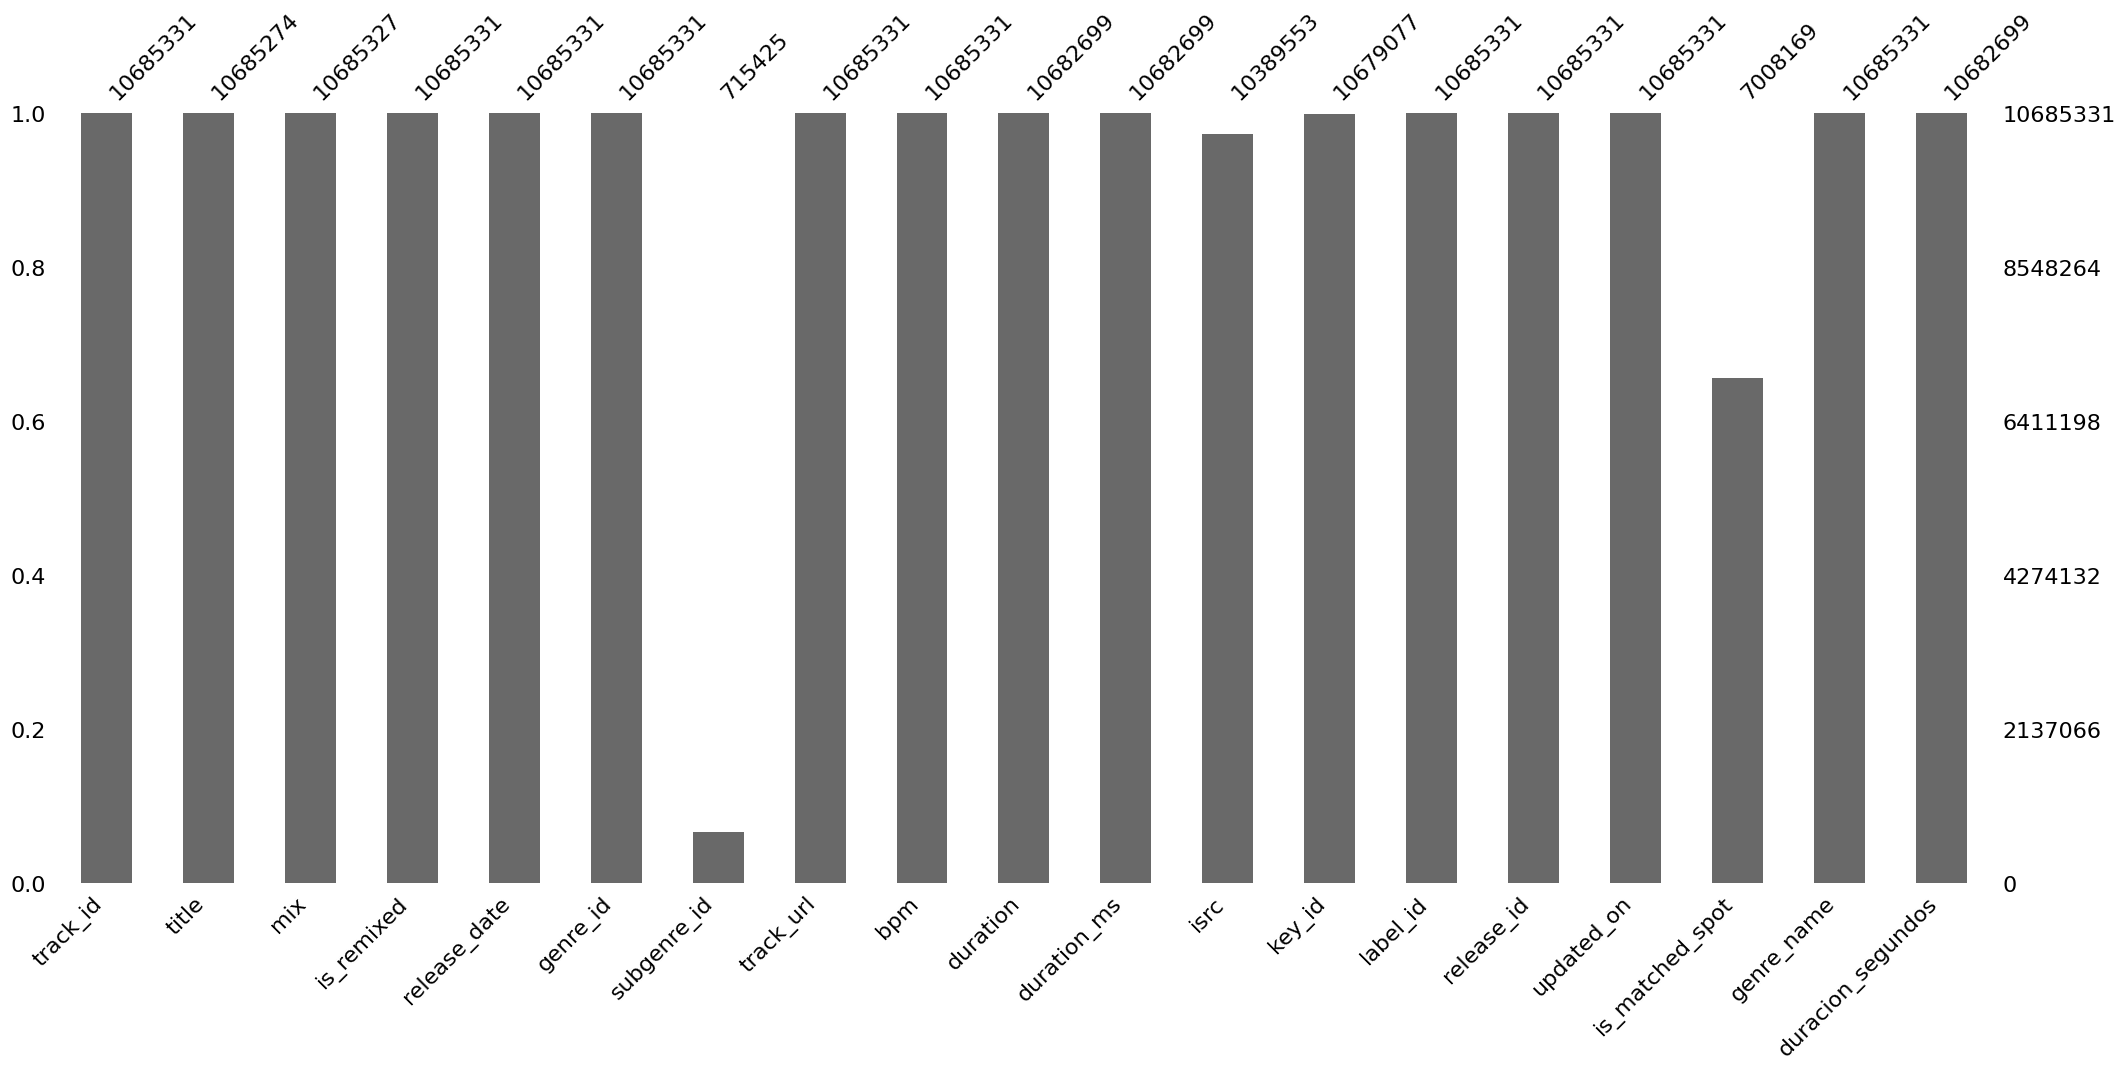

In [47]:
msno.bar(df_final)

## Eliminación de Algunas columnas por tener nulos y porque no interesan en el presente análisis

In [48]:
#Quitar subgenre_id porque faltan muchos datos y (is_matched_spot,duration, isrc, key_id, label_id) porque no nos interesan en este análisis
df_final = df_final.drop(columns=['subgenre_id','is_matched_spot','duration','isrc','track_url','key_id','label_id'], axis = 1)

In [49]:
#Reemplazar los 0s por nan a bpm, duration_ms y duracion_segundos porque eran las columnas que tienen un minimo de 0 y no tiene sentido
df_final[['bpm','duration_ms','duracion_segundos']] = df_final[['bpm','duration_ms','duracion_segundos']].replace(0, np.nan)
df_final[['bpm','duration_ms','duracion_segundos']].head()

bpm  duration_ms  duracion_segundos
0  130.0     408830.0            408.830
1  124.0     407439.0            407.439
2  124.0     437066.0            437.066
3   93.0     387096.0            387.096
4  125.0     460800.0            460.800

In [50]:
nulos = df_final.isnull().sum()
nulos

track_id                 0
title                   57
mix                      4
is_remixed               0
release_date             0
genre_id                 0
bpm                  37972
duration_ms           2713
release_id               0
updated_on               0
genre_name               0
duracion_segundos     2713
dtype: int64

In [51]:
nulos_por_columna = df_final[['bpm', 'duration_ms', 'duracion_segundos']].isnull().sum()
nulos_por_columna

bpm                  37972
duration_ms           2713
duracion_segundos     2713
dtype: int64

<Axes: >

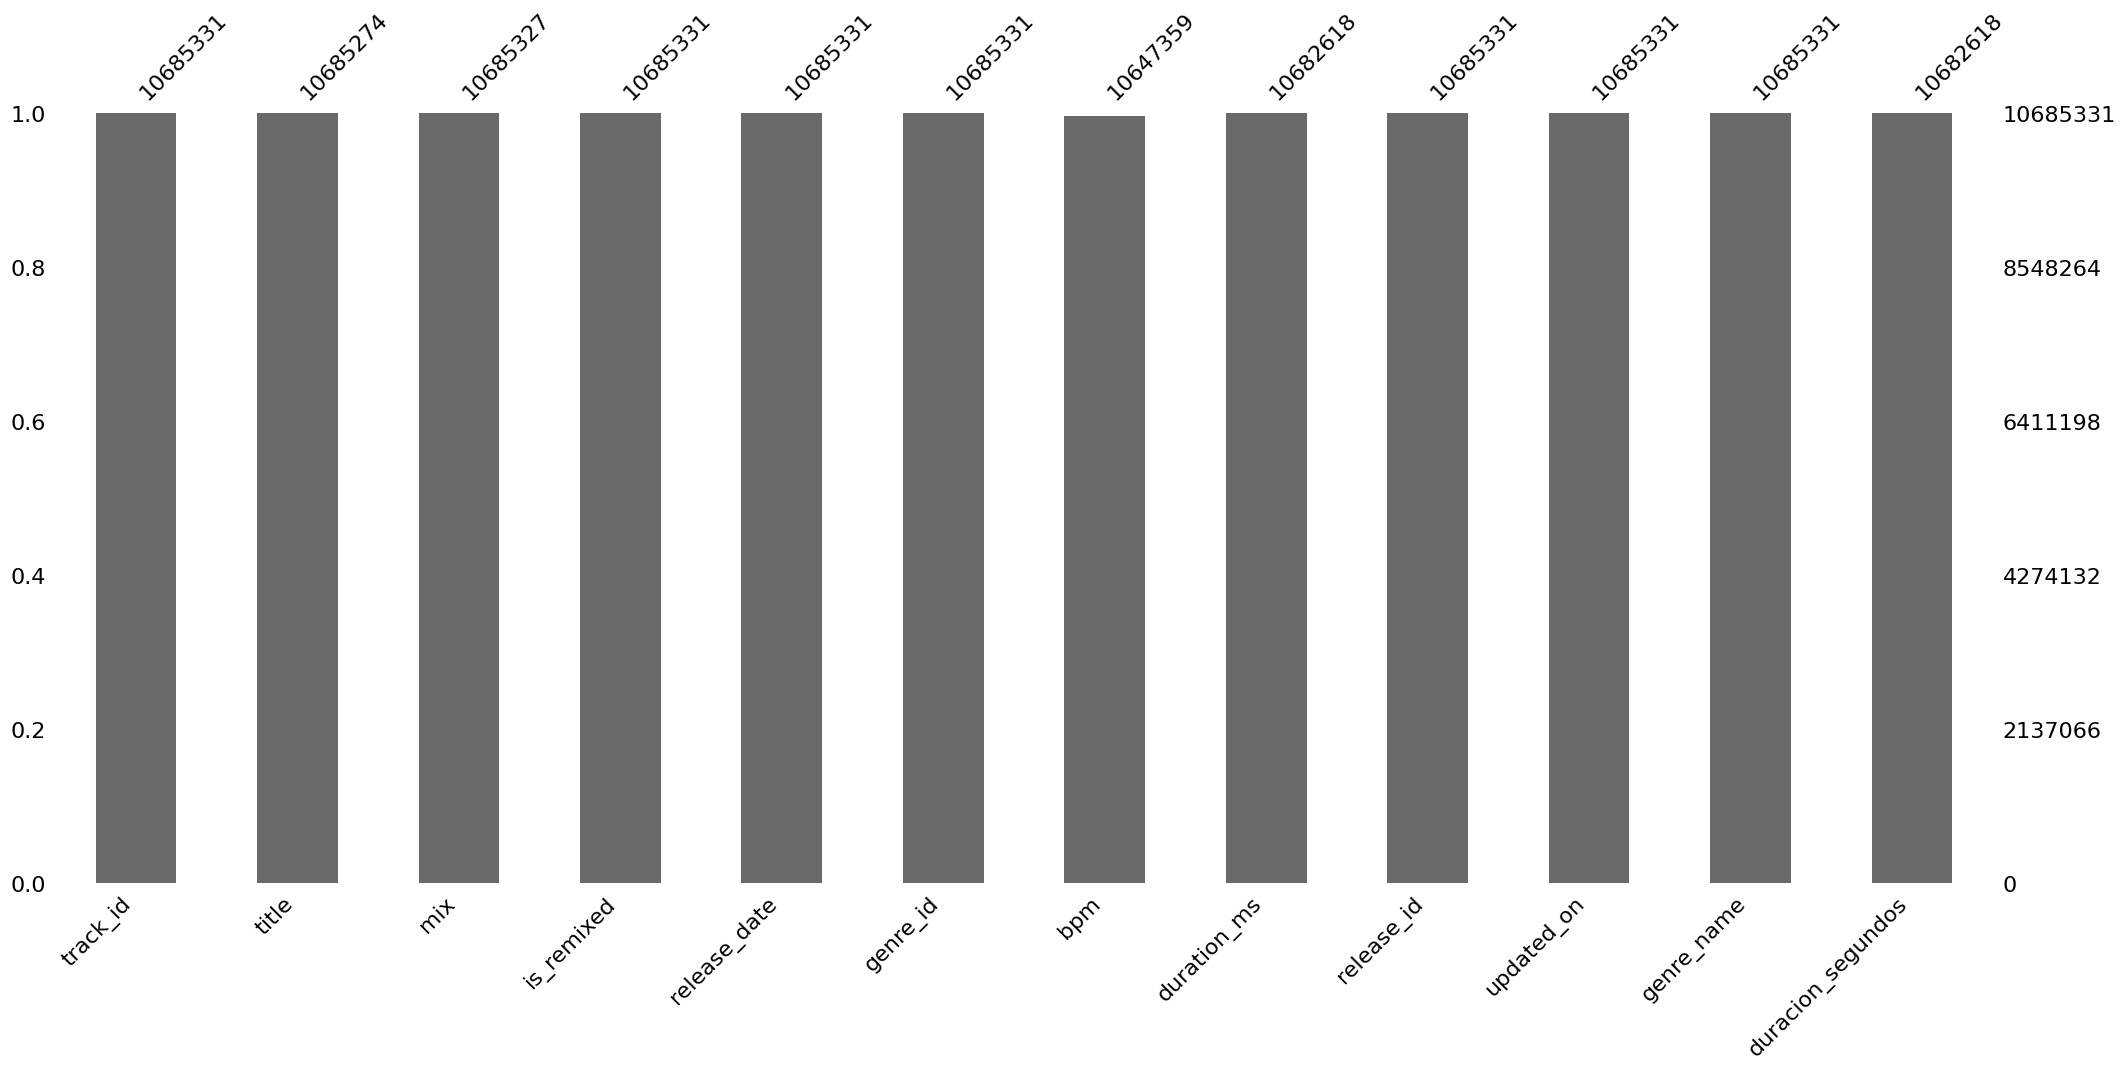

In [52]:
msno.bar(df_final)

<Axes: >

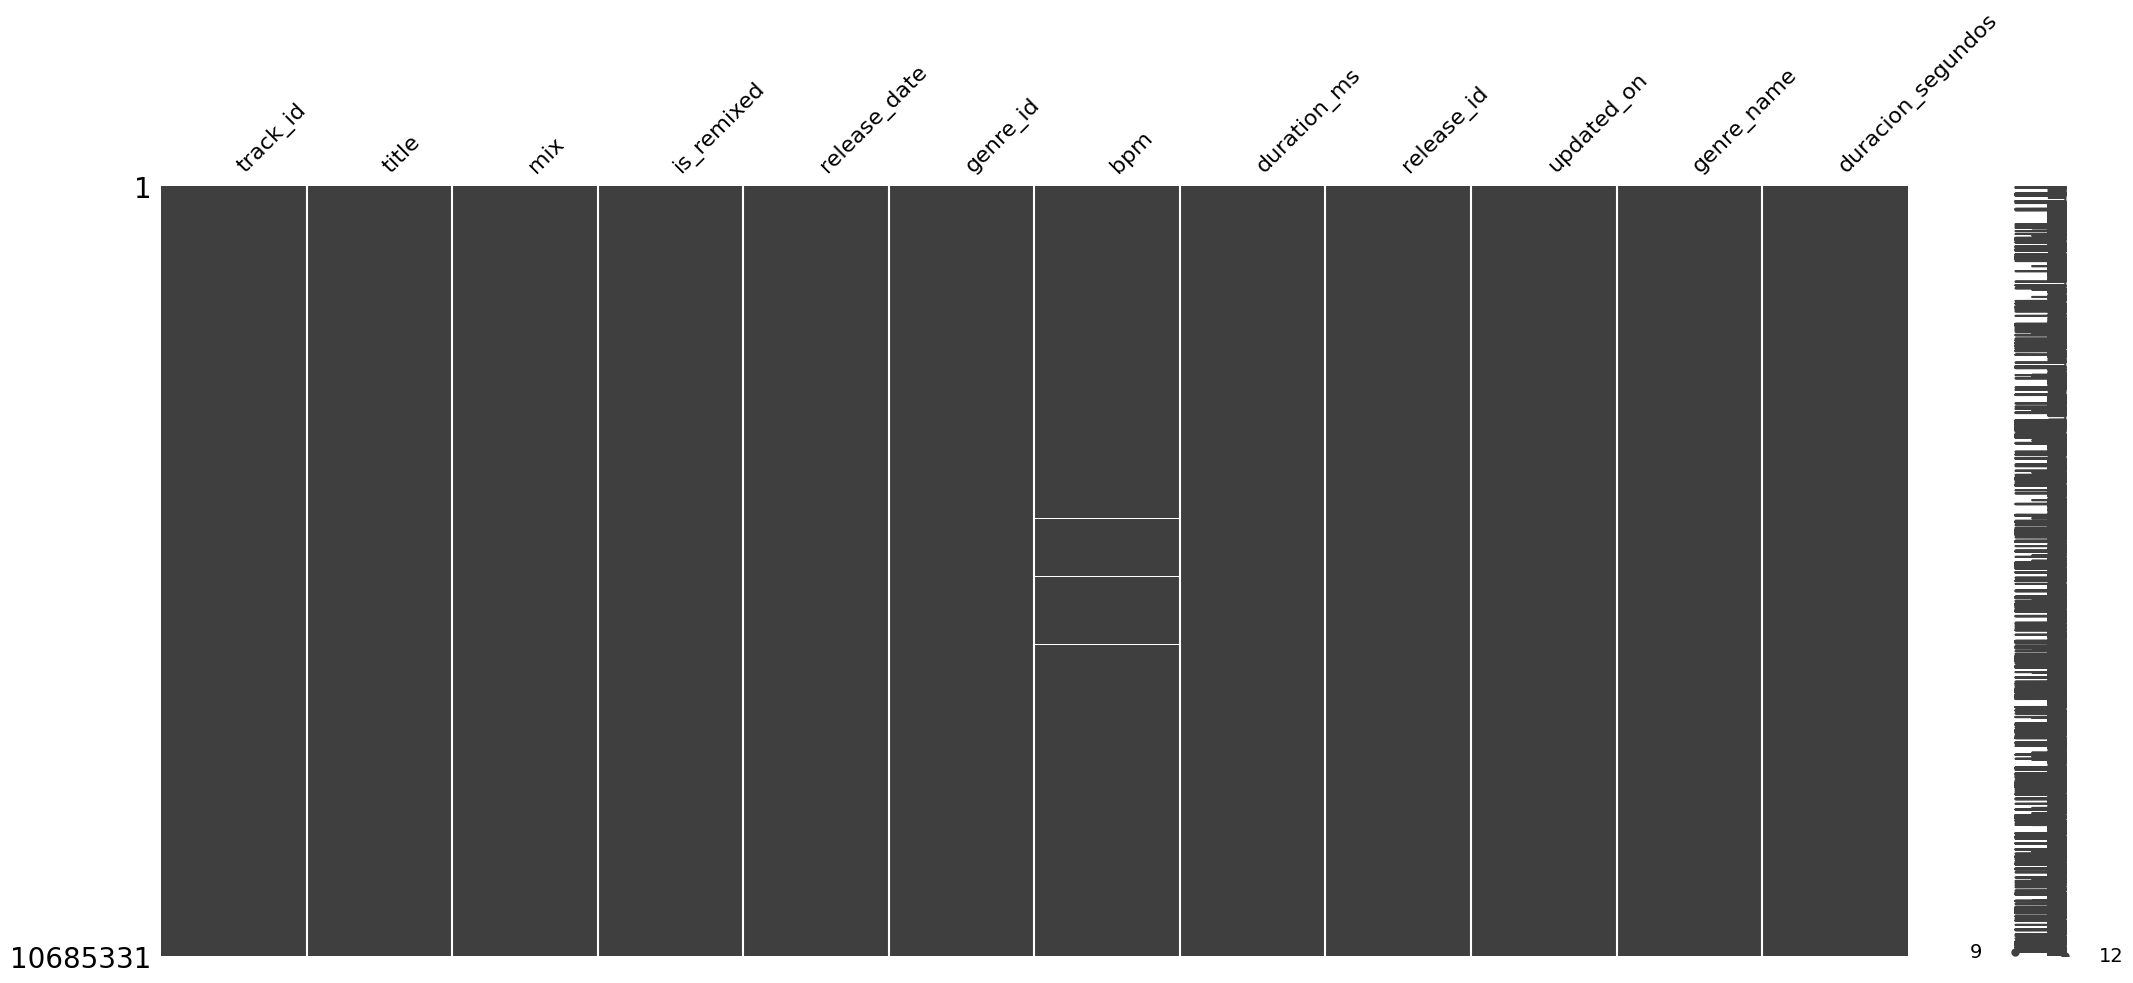

In [53]:
msno.matrix(df_final)

<Axes: >

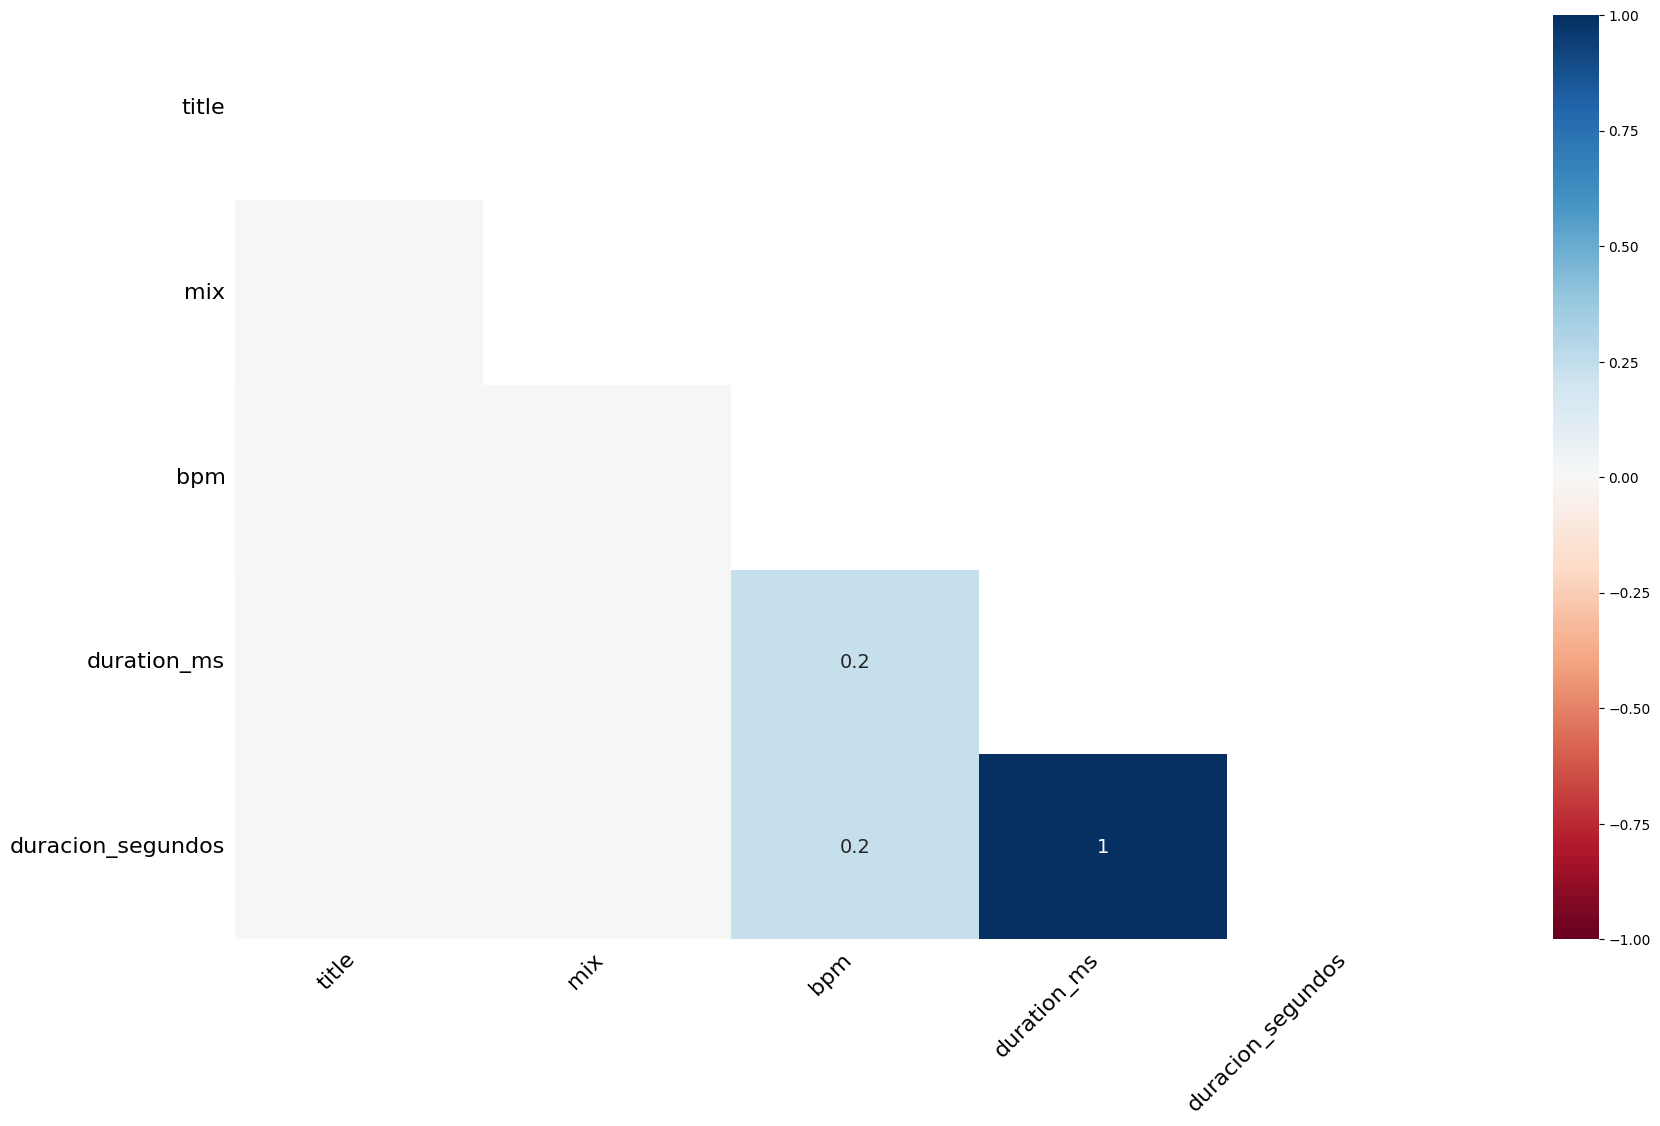

In [54]:
msno.heatmap(df_final)

## Imputación

In [55]:
nulos

track_id                 0
title                   57
mix                      4
is_remixed               0
release_date             0
genre_id                 0
bpm                  37972
duration_ms           2713
release_id               0
updated_on               0
genre_name               0
duracion_segundos     2713
dtype: int64

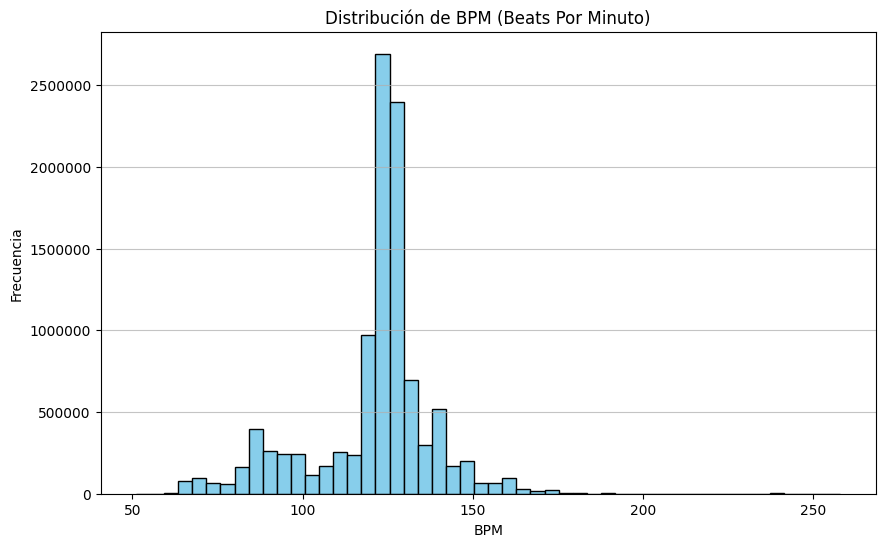

In [56]:
# Visualización 1: Distribución de BPM
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_final['bpm'], bins = 50, color = 'skyblue', edgecolor = 'black')
ax.set_title('Distribución de BPM (Beats Por Minuto)')
ax.set_xlabel('BPM')
ax.set_ylabel('Frecuencia')
ax.grid(axis='y', alpha = 0.75)
plt.gca().ticklabel_format(style='plain', axis = 'y')

In [57]:
df_final['bpm'].mean()

121.15511151638637

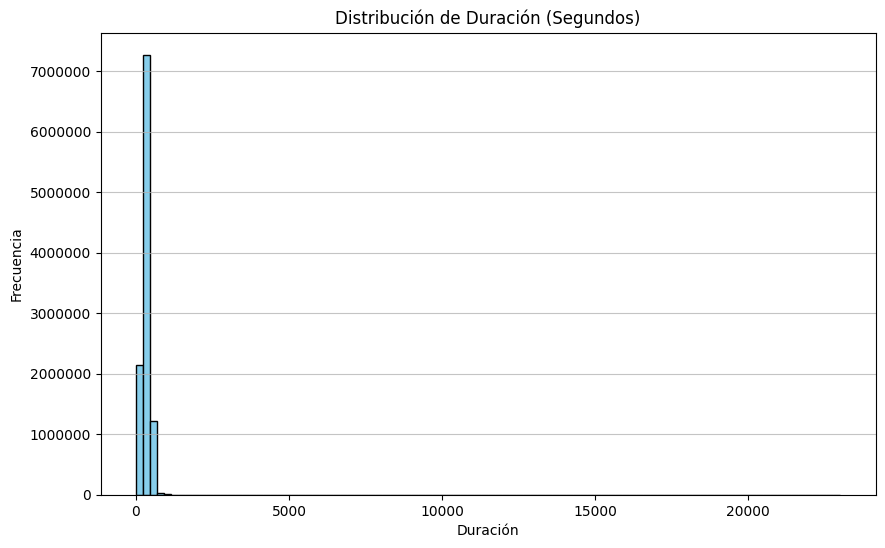

In [58]:
# Distribución de Duracion Segundos
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_final['duracion_segundos'], bins = 100, color = 'skyblue', edgecolor = 'black')
ax.set_title('Distribución de Duración (Segundos)')
ax.set_xlabel('Duración')
ax.set_ylabel('Frecuencia')
ax.grid(axis='y', alpha = 0.75)
plt.gca().ticklabel_format(style='plain', axis = 'y')

In [59]:
df_final['duracion_segundos'].mean()

344.5459682325989

### Decisión

Se decide imputar los pocos nulos que se tienen en el dataset (0.3% para bpm y 0.02% para duration) reemplazandolos por la media, ya que es un valor que se encuentra en gran medida a lo largo del dataset.

In [60]:
# Reemplazar con la media
from sklearn.impute import SimpleImputer

valores = df_final[['bpm','duration_ms','duracion_segundos']].values
imputador = SimpleImputer(missing_values = np.nan, strategy = 'mean') 
transformados = imputador.fit_transform(valores)
transformados = pd.DataFrame(transformados)
df_final[['bpm','duration_ms','duracion_segundos']] = transformados
print(transformados.head().round(2))

       0         1       2
0  130.0  408830.0  408.83
1  124.0  407439.0  407.44
2  124.0  437066.0  437.07
3   93.0  387096.0  387.10
4  125.0  460800.0  460.80


In [61]:
nulos = df_final.isnull().sum()
nulos

track_id              0
title                57
mix                   4
is_remixed            0
release_date          0
genre_id              0
bpm                   0
duration_ms           0
release_id            0
updated_on            0
genre_name            0
duracion_segundos     0
dtype: int64

# Visualización 1: Histograma
## Pregunta - Hipótesis
- Pregunta: ¿Cuál es la distribución de los BPM de las canciones en el dataset? ¿Hay un BPM común que predomine en todos los géneros?
- Hipótesis: Los géneros van a presentar en general BPM distintos, reflejando las diferencias entre los géneros musicales.
    

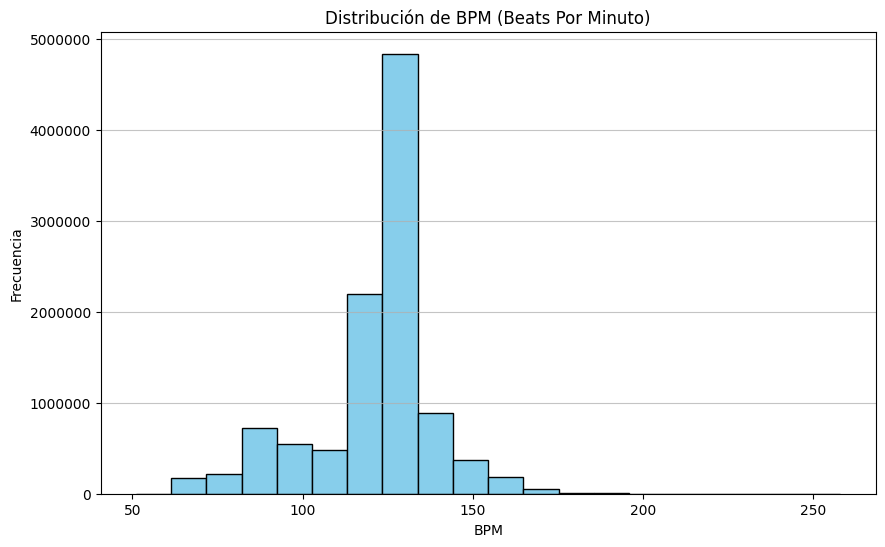

In [62]:
# Visualización 1: Distribución de BPM
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_final['bpm'], bins = 20, color = 'skyblue', edgecolor = 'black')
ax.set_title('Distribución de BPM (Beats Por Minuto)')
ax.set_xlabel('BPM')
ax.set_ylabel('Frecuencia')
ax.grid(axis='y', alpha = 0.75)
plt.gca().ticklabel_format(style='plain', axis = 'y')
fig.savefig('mpl_histograma.png')

## Análisis Visualización 1
- La mayoría de los datos se concentran alrededor de 125-150 BPM. Esto sugiere que hay una fuerte tendencia hacia este rango de BPM
- Se podría afirmar que la distribución de los BPM parece ser unimodal, lo que significa que hay un solo pico principal. Esto puede indicar que hay un 'tempo' preferido o más común entre las piezas de música o las muestras de datos analizados.
- Luego del rango de mayor frecuencia hay una caída abrupta, lo que da a entender que muy pocas canciones se encuentran con BPMs por encima de los 150

# Visualización 2: Serie de Tiempo
## Pregunta - Hipótesis

- Pregunta: ¿Cómo ha cambiado la popularidad de un género musical específico o la cantidad de canciones producidas a lo largo del tiempo?
- Hipótesis: Existe una tendencia creciente en la producción de canciones de ciertos géneros, posiblemente debido a cambios en las preferencias culturales y tecnológicas.

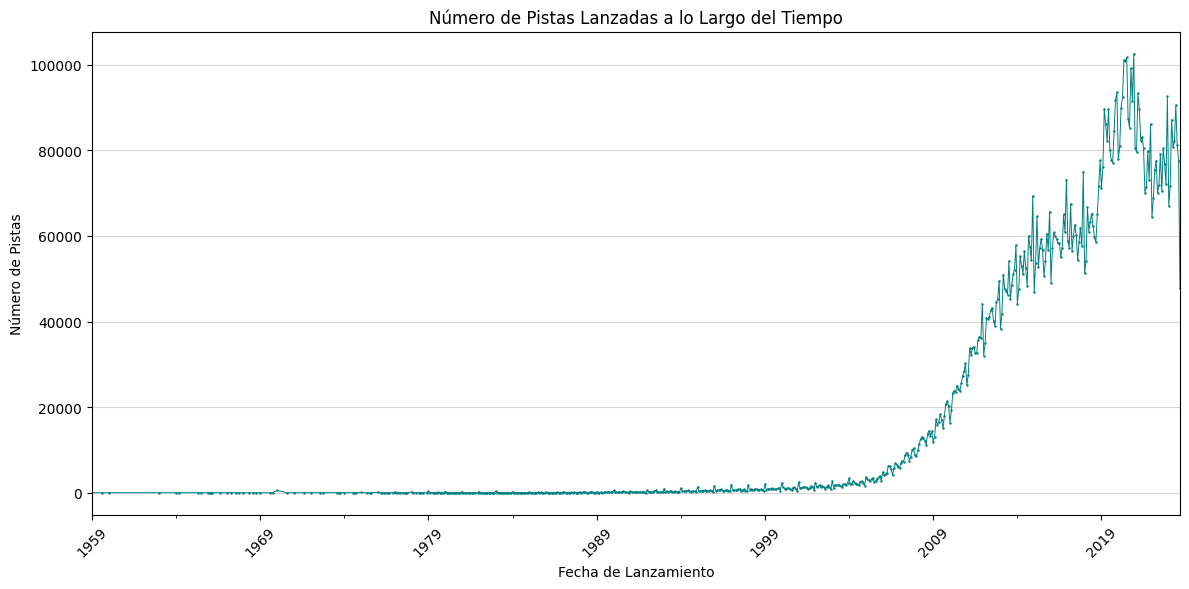

In [63]:
df_final['release_date'] = pd.to_datetime(df_final['release_date'])
tendencia_lanzamientos = df_final.groupby(df_final['release_date'].dt.to_period("M")).size()

# Visualización 2: Número de Pistas Lanzadas a lo Largo del Tiempo
fig, ax = plt.subplots(figsize = (12, 6))
tendencia_lanzamientos.plot(kind = 'line', color = 'teal', marker = '.', linewidth=0.7, markersize=1.5)
ax.set_title('Número de Pistas Lanzadas a lo Largo del Tiempo')
ax.set_xlabel('Fecha de Lanzamiento')
ax.set_ylabel('Número de Pistas')
ax.grid(axis='y', alpha=0.5)
ax.set_xlim(left=pd.Timestamp('1959-01-01'))
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('mpl_serie_de_tiempo')


## Análisis Visualización 2
- Hay un claro crecimiento exponencial en el número de pistas lanzadas a lo largo del tiempo. El crecimiento es lento y estable en las primeras décadas, y se vuelve mucho más pronunciado después del año 2000.
- El marcado aumento en el número de pistas lanzadas después de los años 2000 puede estar relacionado con la digitalización de la música. Esto incluye el desarrollo y popularización de la música digital, servicios de streaming y plataformas de distribución en línea, lo que facilita la producción y publicación de música.
- En los últimos años de la gráfica, se observa una mayor volatilidad con picos más altos y caídas abruptas. Esto podría deberse a factores estacionales, tendencias de lanzamientos (como álbumes o singles), o posiblemente cambios en cómo se cuenta el número de pistas (por ejemplo, contando remixes o versiones diferentes).
- El gráfico refleja la influencia de la tecnología en la producción musical. A medida que ha sido más fácil grabar y distribuir música, más artistas han podido lanzar sus trabajos al público.
- Este crecimiento también puede indicar cambios estructurales en la industria de la música, donde los artistas ahora tienen más control sobre su producción y distribución, posiblemente reduciendo la barrera de entrada al mercado de la música.

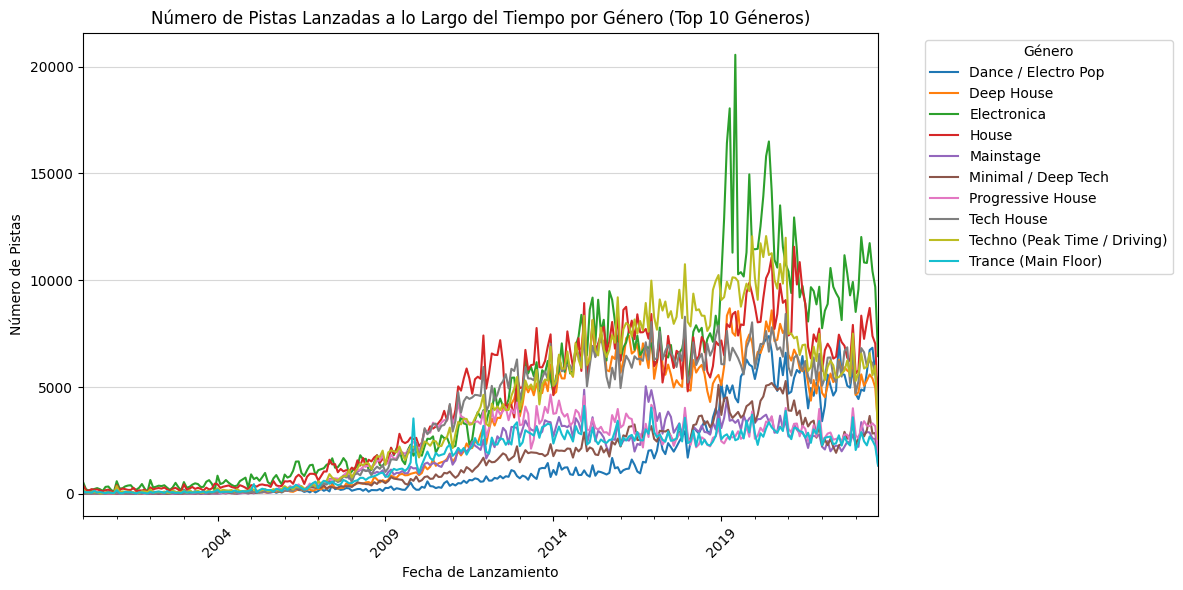

In [64]:
df_final['release_date'] = pd.to_datetime(df_final['release_date'])
top10_generos = df_final['genre_name'].value_counts().head(10).index
df_top10_generos = df_final[df_final['genre_name'].isin(top10_generos)]
tendencia_lanzamientos = df_top10_generos.groupby(['genre_name', df_final['release_date'].dt.to_period("M")]).size()
tendencia_lanzamientos = tendencia_lanzamientos.unstack(level=0)

# Visualización 2.1: Número de Pistas Lanzadas a lo Largo del Tiempo por Género (Top 10 Géneros)
fig, ax = plt.subplots(figsize=(12, 6))
for genre in tendencia_lanzamientos.columns:
    tendencia_lanzamientos[genre].plot(kind='line', ax=ax, label=genre)

ax.set_title('Número de Pistas Lanzadas a lo Largo del Tiempo por Género (Top 10 Géneros)')
ax.set_xlabel('Fecha de Lanzamiento')
ax.set_ylabel('Número de Pistas')
ax.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.5)
ax.set_xlim(left=pd.Timestamp('2000-01-01'))
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('mpl_serie_de_tiempo_genero')

plt.show() 

## Análisis Visualización 2.1

- Se observa que ciertos géneros como Electrónica, Techno y House han tenido picos significativos en el número de lanzamientos a lo largo del tiempo. Esto podría sugerir un aumento en la popularidad o una respuesta a eventos específicos del mercado, como festivales o tendencias culturales.
- Los picos anormales, especialmente el pico extremadamente alto en un género alrededor del año 2019, podrían ser el resultado de igualmente tendencias mundiales en cuanto al gusto en la música Electrónica, Tecnho, House, etc.

# Visualización 3
## Pregunta - Hipótesis
- Pregunta: ¿Cómo se distribuyen los géneros musicales en el dataset? ¿Existe un género que domine claramente sobre los demás?
- Hipótesis: Un pequeño número de géneros musicales populares representan una gran proporción del dataset, indicando una concentración de preferencias en el mercado.


In [65]:
df_final['genre_name'].value_counts()

genre_name
Electronica                             1349722
House                                   1205119
Techno (Peak Time / Driving)            1162483
Tech House                              1002904
Deep House                               895499
Progressive House                        575370
Mainstage                                498698
Trance (Main Floor)                      477997
Dance / Electro Pop                      472783
Minimal / Deep Tech                      449823
Trap / Wave                              351635
Drum & Bass                              346977
Psy-Trance                               205955
Breaks / Breakbeat / UK Bass             197741
Melodic House & Techno                   187735
Indie Dance                              181853
Hard Dance / Hardcore                    177874
Dubstep                                  154031
Nu Disco / Disco                         153421
Techno (Raw / Deep / Hypnotic)           125391
Organic House / Downtempo    

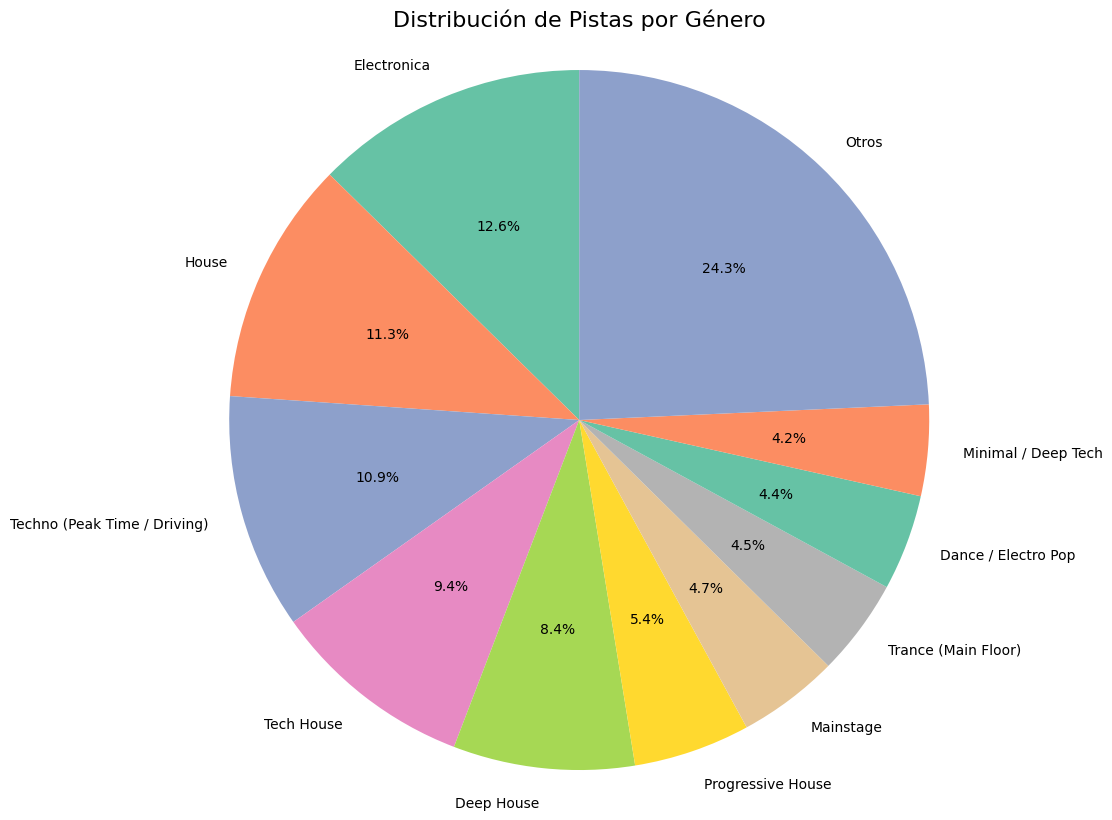

In [66]:
conteo_generos = df_final['genre_name'].value_counts()

# Como hay demasiadas categorías pequeñas, agruparlas en 'Otros'
if len(conteo_generos) > 10:
    conteo_otros = conteo_generos[10:].sum()
    conteo_generos = conteo_generos[:10]
    conteo_generos['Otros'] = conteo_otros

# Visualización 3: Distribución por Género
fig, ax = plt.subplots(figsize=(12, 10))
ax.pie(conteo_generos, labels = conteo_generos.index, autopct = '%1.1f%%', startangle = 90, colors = sns.color_palette('Set2'))
ax.set_title('Distribución de Pistas por Género', fontdict={'fontsize':16})
plt.axis('equal')
fig.savefig('mpl_piechart.png')




## Análisis Visualización 3
- Los géneros con las mayores porciones son 'Electronica' con 12.6% y 'House' con 11.3%. Esto sugiere que son los géneros más populares o con más pistas disponibles dentro del conjunto de datos analizado.
- La gráfica muestra una amplia variedad de géneros, que van desde 'Techno (Peak Time / Driving)' con 10.9% hasta géneros con porciones más pequeñas como 'Psy-Trance', 'Drum & Bass', 'Trap / Wave', cada uno con 1.9%. Esta diversidad indica una industria musical rica y variada.
- : La categoría 'Otros' representa un 12.2%, lo que indica que hay una cantidad significativa de pistas que no encajan en las categorías listadas o que representan una gran cantidad de subgéneros o géneros menos comunes. Esto también puede sugerir que la música está evolucionando y que surgen nuevos géneros que aún no han sido categorizados de manera convencional.
- Las variantes de House y Techno parecen ser muy populares, ya que ocupan varias categorías en el gráfico, tales como 'Tech House', 'Deep House', 'Melodic House & Techno', y 'Techno (Peak Time / Driving)', lo que refleja la popularidad de estos estilos en la cultura musical electrónica actual.

# Visualización 4
## Pregunta - Análisis:
- Pregunta: ¿Cuáles son las diferencias en los BPMs entre los géneros musicales?
- Hipótesis: Algunos géneros musicales tienen características más uniformes (menor dispersión), lo que indica un estilo más coherente.


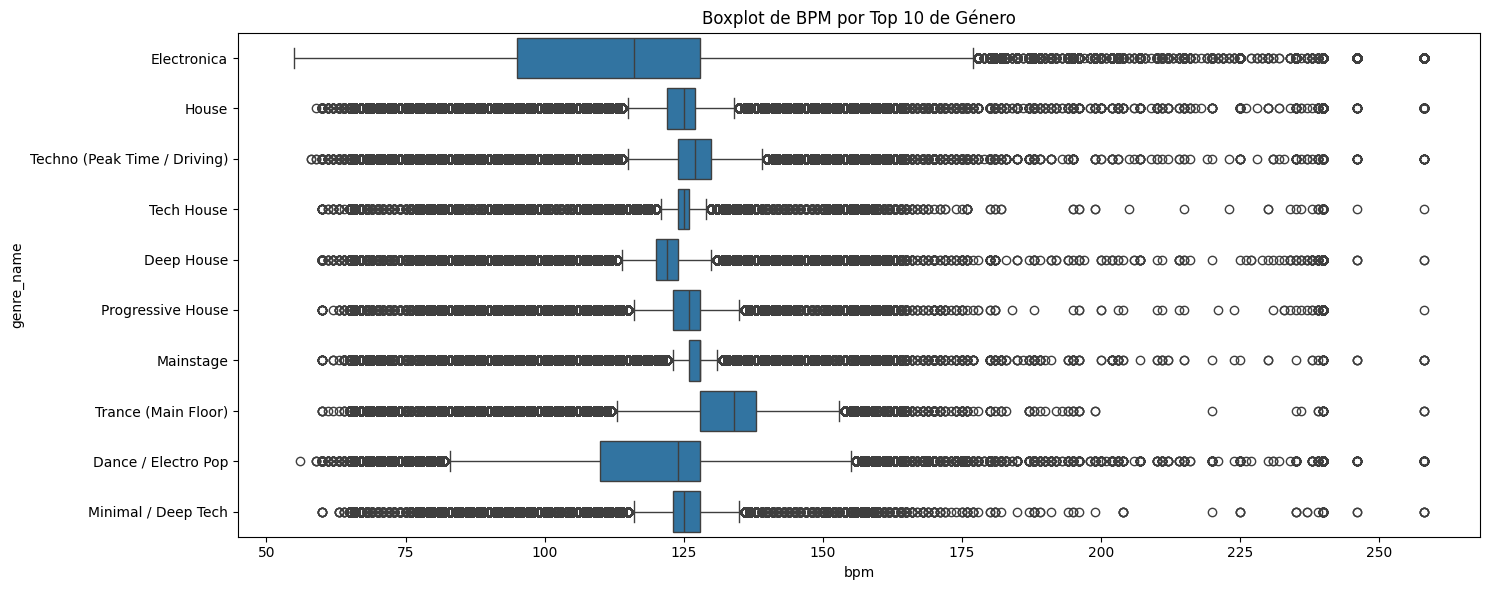

In [67]:
# sns.set_palette("Set2")
top10_generos = df_final['genre_name'].value_counts().head(10).index
df_top10_generos = df_final[df_final['genre_name'].isin(top10_generos)]

# Gráfica 1: Boxplot de BPM por Género
plt.figure(figsize=(15, 6))
plt.subplot()
ax = sns.boxplot(x = 'bpm', y = 'genre_name', data = df_top10_generos, order = top10_generos)
plt.title('Boxplot de BPM por Top 10 de Género')
plt.tight_layout()
plt.savefig('sns_boxplot.png')
plt.show()



## Análisis Visualización 4
- La mediana de BPM varía significativamente entre los géneros. Algunos géneros como 'Electronica' tienen medianas más bajas y rangos más amplios, lo que indica una mayor variabilidad en los BPM. Otros géneros, como 'Dance / Electro Pop', muestran una mediana más alta con menos variabilidad.
- Casi todos los géneros tienen muchos valores atípicos, indicando que hay pistas con BPMs significativamente más altos o más bajos que la mayoría de las pistas dentro de ese género. Esto puede ser debido a la experimentación artística o a la influencia de subgéneros.
- Géneros como 'Techno (Peak Time / Driving)' y 'Tech House' tienen boxplots relativamente largos con muchas observaciones fuera de los 'bigotes', sugiriendo que, aunque hay un BPM predominante, hay bastante diversidad dentro del género.
- Los géneros de música electrónica tienden a tener rangos de BPM bastante definidos, lo que sugiere que los artistas y productores se adhieren a ciertas normas de tempo para cumplir con las expectativas del género. Los géneros con rangos más estrechos, como 'Mainstage', podrían tener una identidad más fuerte asociada con un BPM específico.

# Visualización 5 y 6
## Pregunta - Hipótesis
- Pregunta: En general, se realizan lanzamientos de manera constante a  lo largo del año?
- Hipótesis: Deben haber épocas de mayor cantidad de lanzamientos, debido a factores tanto financieros, como a tendencias en el mercado.

- Pregunta: ¿Cuál es la relación entre la duración de la canción y los BPMs y cómo se distribuyen entre las canciones?
- Hipótesis: Entre más larga la canción, mayor serán los BPMs, debido a que pueden deberse a sets de música electrónica o tecno con un ritmo elevado.



In [68]:
df_final['release_date'] = pd.to_datetime(df_final['release_date'])
df_final['release_month'] = df_final['release_date'].dt.month
release_counts = df_final['release_month'].value_counts()
release_counts

release_month
12    978060
3     955486
6     950852
7     924776
5     914915
4     910293
10    879916
9     862172
11    858765
8     843981
2     818560
1     787555
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_20468\2147150246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10_generos['release_date'] = pd.to_datetime(df_top10_generos['release_date'])
C:\Users\user\AppData\Local\Temp\ipykernel_20468\2147150246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10_generos['release_month'] = df_top10_generos['release_date'].dt.month


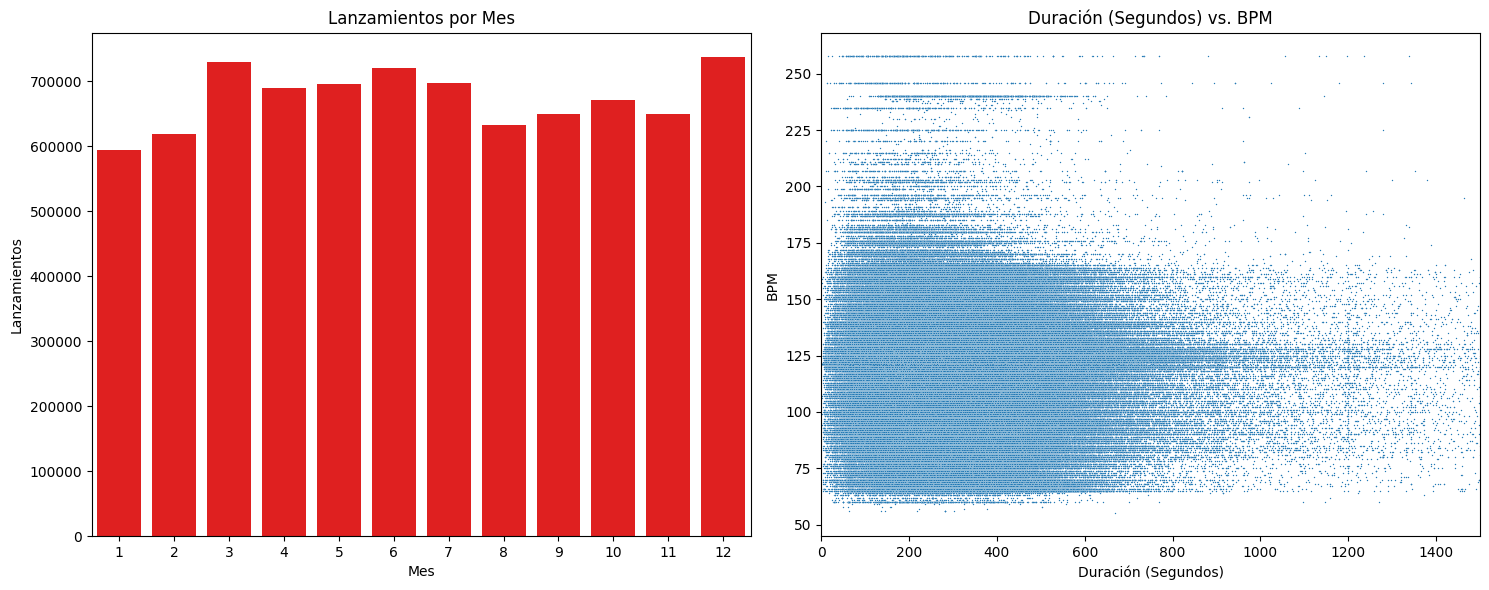

In [69]:
df_top10_generos['release_date'] = pd.to_datetime(df_top10_generos['release_date'])
df_top10_generos['release_month'] = df_top10_generos['release_date'].dt.month

plt.figure(figsize=(15, 6))
# Gráfica 2: Countplot de Lanzamientos por Mes
plt.subplot(1, 2, 1)
sns.countplot(x = 'release_month', data = df_top10_generos, color = 'red')
plt.title('Lanzamientos por Mes')
plt.gca().ticklabel_format(style = 'plain', axis = 'y')
plt.xlabel('Mes')
plt.ylabel('Lanzamientos')
# plt.ylim(750000)



# Gráfica 3: Scatterplot de Duración vs. BPM
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'duracion_segundos', y = 'bpm', data = df_top10_generos, s = 1)
plt.title('Duración (Segundos) vs. BPM')
plt.xlabel('Duración (Segundos)')
plt.ylabel('BPM')
plt.xlim(0,1500)

plt.tight_layout()
plt.savefig('sns_countplot_scatterplot.png')
plt.show()

## Análisis Visualización 5
- El mes con menos lanzamientos es Enero, lo que puede indicar una desaceleración después de la temporada de vacaciones o el cierre del año fiscal para muchas compañías discográficas.
- De manera contraria, el mes con mayor cantidad de lanzamientos es Diciembre, época en la que se deben generar mayor cantidad de ingresos en las compañías discográficas debido a la alta demanda alrededor del mundo.

## Análisis Visualización 6
- No hay una tendencia clara que relacione la duración de las pistas con los BPM, lo que sugiere que la duración de una pista no está directamente relacionada con su tempo.
- La mayoría de las pistas tienen una duración que va de los 0 a los 4000 segundos (hasta poco más de una hora), y los BPM están principalmente entre 50 y 200.
- Los puntos que están más alejados en la parte derecha del gráfico podrían representar mixes o sets más largos, mientras que aquellos con BPM más altos podrían ser géneros de música electrónica rápida o remixes con tempos incrementados.

# Identificación de Outliers


## Z Score

El análisis se hizo del top 10 géneros



In [70]:
df_final['release_date'] = pd.to_datetime(df_final['release_date'])
top10_generos = df_final['genre_name'].value_counts().head(10).index
df_top10_generos = df_final[df_final['genre_name'].isin(top10_generos)]
df_top10_generos.shape

(8090398, 13)

In [71]:
def process_and_plot_genre(df, genre, position, nrows, ncols, fig, column_to_plot):
    # Filtrar la data dado el Género
    datos = df[df['genre_name'] == genre]
    l = [x for x in df.columns if x in ['release_date', 'bpm', 'duration_ms', 'duracion_segundos']]
    datos = datos[l].reset_index().drop(columns=['index'])
    datos['release_date'] = pd.to_datetime(datos['release_date'])
    
    # Convertir a Z-Score
    datos_z = pd.DataFrame()
    for col_name in datos.columns[1:]:
        datos_z[col_name] = (datos[col_name] - datos[col_name].mean()) / datos[col_name].std()
    datos_z['release_date'] = datos['release_date']
    
    # Marcar como 'Normal' or 'Atípico'
    for col_name in ['bpm', 'duration_ms', 'duracion_segundos']:
        normal_col_name = f'{col_name}_normal'
        datos_z[normal_col_name] = datos_z[col_name].apply(lambda x: 'Atípico' if (x > 2 or x < -2) else 'Normal')
    
    # Graficar en cada subplot la columna a plotear
    if column_to_plot == 'bpm':
        ax = fig.add_subplot(nrows, ncols, position)
        sns.scatterplot(x='release_date', y='bpm', hue='bpm_normal', data=datos_z, s=5, ax=ax)
        ax.set_xlabel('Release Date')
        ax.set_title(f'{genre}')
    elif column_to_plot == 'duration_ms':
        ax = fig.add_subplot(nrows, ncols, position)
        sns.scatterplot(x='release_date', y='duration_ms', hue='duration_ms_normal', data=datos_z, s=5, ax=ax)
        ax.set_xlabel('Release Date')
        ax.set_title(f'{genre}')
    elif column_to_plot == 'duracion_segundos': 
        ax = fig.add_subplot(nrows, ncols, position)
        sns.scatterplot(x='release_date', y='duracion_segundos', hue='duracion_segundos_normal', data=datos_z, s=5, ax=ax)
        ax.set_xlabel('Release Date')
        ax.set_title(f'{genre}')
    else:
        print('Columna inválida')

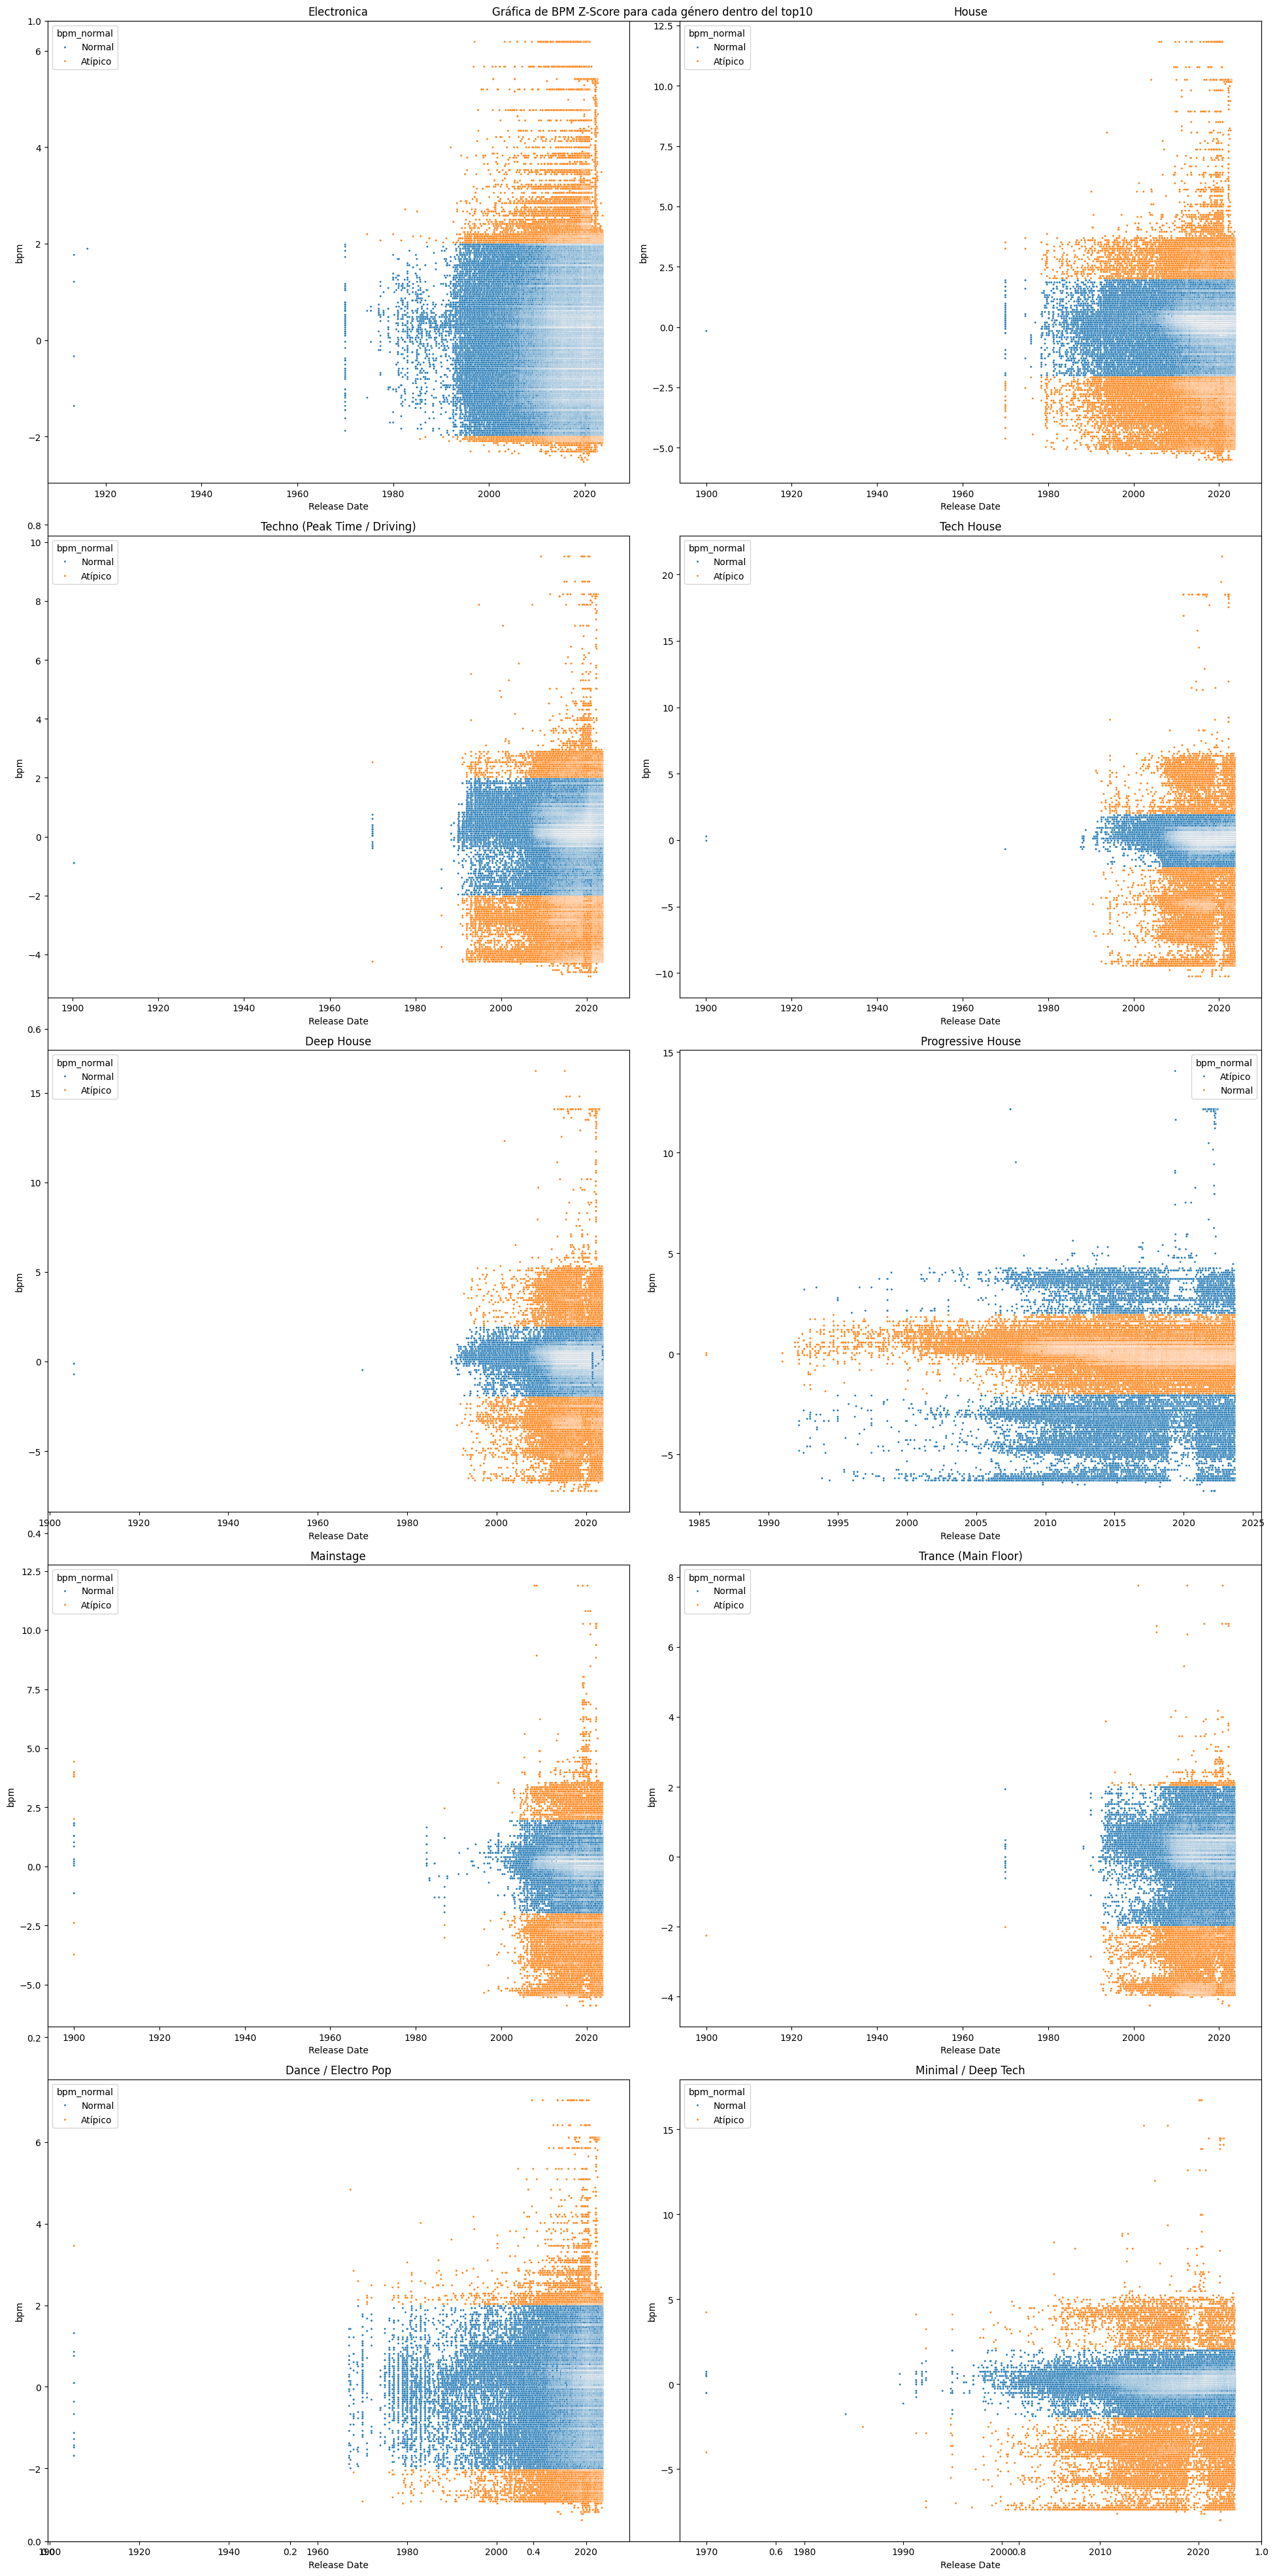

In [72]:
# Setear el lienzo para BPM
fig = plt.figure(figsize=(20, 40))
plt.title('Gráfica de BPM Z-Score para cada género dentro del top10 ')

# Procesar los top 10 géneros y plotearlos por bpm
for index, genre in enumerate(top10_generos, start=1):
    process_and_plot_genre(df_top10_generos, genre, index, 5, 2, fig, 'bpm')
plt.tight_layout()
plt.savefig('z-score_BPM_por_genero.png')
plt.show()

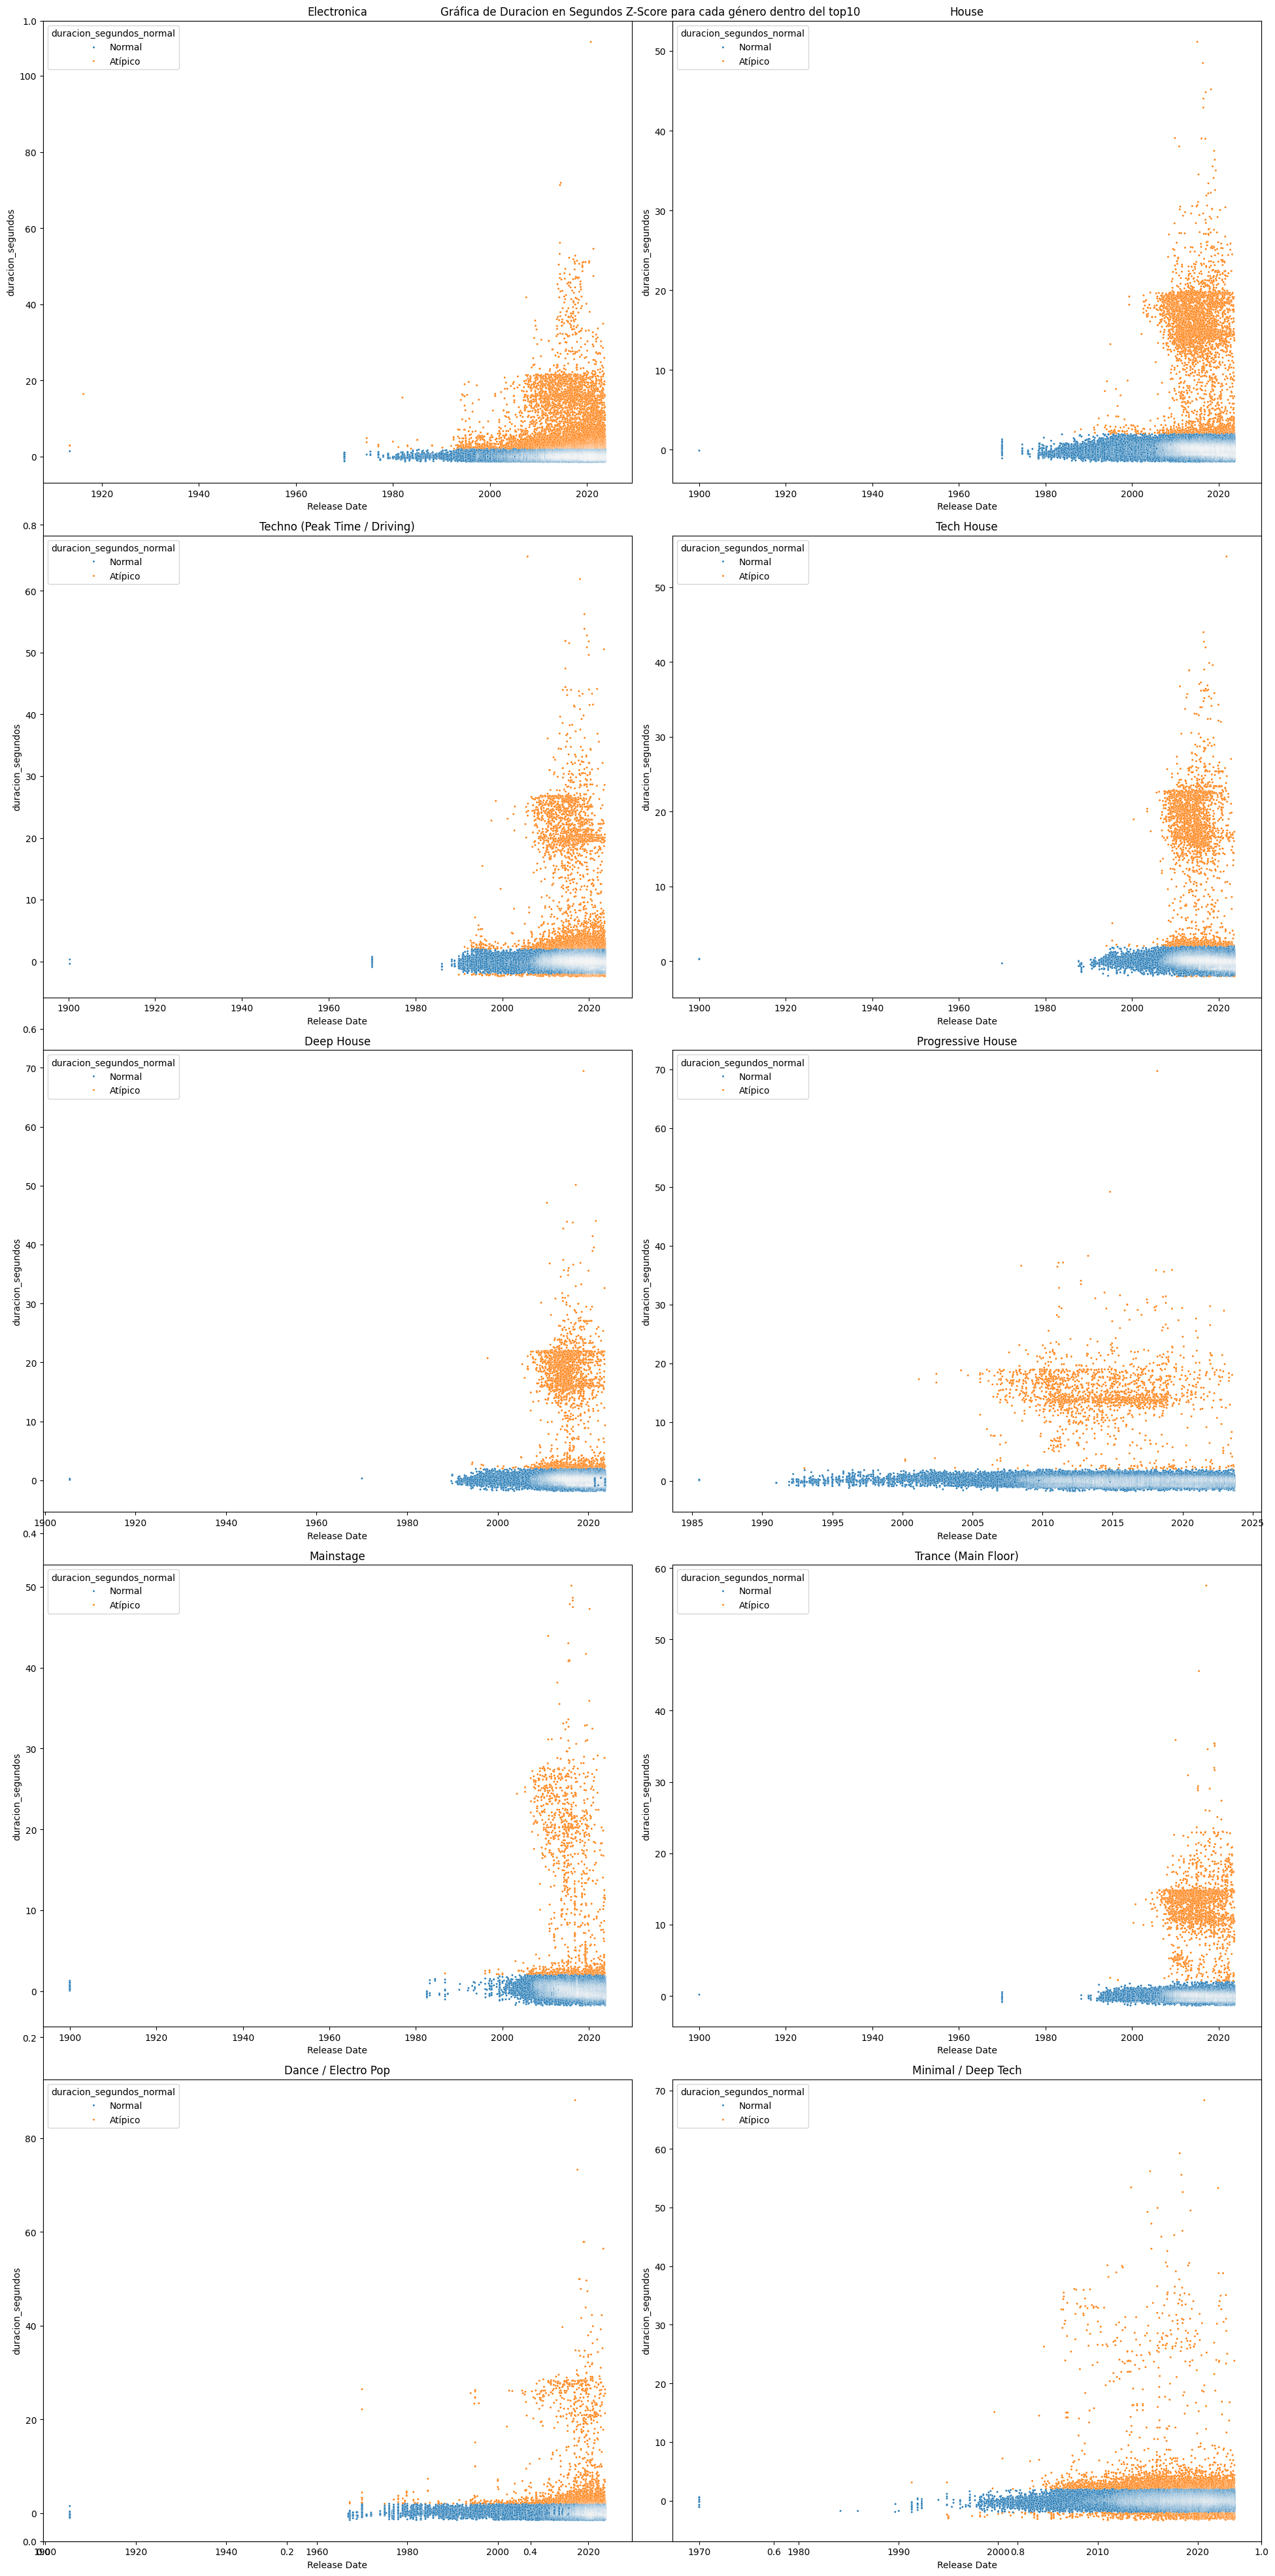

In [73]:
# Setear el lienzo para Duracion Segundos
fig = plt.figure(figsize=(20, 40))
plt.title('Gráfica de Duracion en Segundos Z-Score para cada género dentro del top10 ')

# Procesar los top 10 géneros y plotearlos por bpm
for index, genre in enumerate(top10_generos, start=1):
    process_and_plot_genre(df_top10_generos, genre, index, 5, 2, fig, 'duracion_segundos')

plt.tight_layout()
plt.savefig('z-score_Duracion_Segundos_por_genero.png')
plt.show()

# Feature Selection

El Algoritmo que usaré para la selección de características es Forward Selection debido a:
- Eficiencia Computacional: Como trabajo con una base de datos grande (10 millones de datos) es necesario mantener baja la carga computacional ya que especialmente espero que solo unas pocas variables sean relevantes para la predicción.
- Simplicidad del Modelo: Quiero mantener el modelo lo más simple posible, añadiendo variables solo si aportan significativamente a la predicción.
- Exploración Inicial: Esta es una exploración inicial de los datos y quiero obtener una comprensión rápida de qué variables podrían ser importantes.

Dado que mi objetivo es predecir el 'genre_name' de un nuevo track, es necesario trabajar con variables numéricas, por lo tanto seguiré los siguientes pasos:
1. Eliminar las columnas que no aportan información útil para el modelo, como track_id, title, mix, release_date y updated_on
2. Convertir variables categóricas binarias y nominales en formato numérico. 
3. Codificar la variable 'genre_name' para transformarla en una variable numérica. 
3. Aplicar la función de Forward Selection para identificar las características más significativas para predecir el género

In [74]:
from sklearn.preprocessing import LabelEncoder

# Preprocesamiento de datos
# Eliminar las columnas que no serán útiles para el modelo
df_preprocessed = df_top10_generos.drop(columns=['track_id', 'title', 'mix', 'release_date', 'updated_on'])

# Convertir 'is_remixed' a valores numéricos (0 y 1)
df_preprocessed['is_remixed'] = df_preprocessed['is_remixed'].apply(lambda x: 1 if x == 't' else 0)

# Convertir 'genre_name' a valores numéricos usando Label Encoding
le = LabelEncoder()
df_preprocessed['genre_name_encoded'] = le.fit_transform(df_preprocessed['genre_name'])
target = df_preprocessed['genre_name_encoded']

# Eliminar la columna 'genre_name' original ya que he creado una versión codificada
df_preprocessed = df_preprocessed.drop(columns=['genre_name'])

# Mostrar las primeras filas del dataframe preprocesado y la información
df_preprocessed.head(), df_preprocessed.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8090398 entries, 152 to 10685330
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   is_remixed          int64  
 1   genre_id            int64  
 2   bpm                 float64
 3   duration_ms         float64
 4   release_id          int64  
 5   duracion_segundos   float64
 6   release_month       int32  
 7   genre_name_encoded  int32  
dtypes: float64(3), int32(2), int64(3)
memory usage: 493.8 MB


(      is_remixed  genre_id    bpm  duration_ms  release_id  duracion_segundos  \
 152            0        11  124.0     506842.0      851325            506.842   
 406            0        11  128.0     496040.0      849857            496.040   
 1040           0        11  128.0     405000.0       36617            405.000   
 1280           0        12  125.0     405942.0      127171            405.942   
 1482           0        12  127.0     429504.0      127133            429.504   
 
       release_month  genre_name_encoded  
 152              12                   7  
 406              12                   7  
 1040             11                   7  
 1280              8                   1  
 1482              8                   1  ,
 None)

In [75]:
import statsmodels.api as sm

# Definir la función de Forward Selection
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

# Aplicar la función de Forward Selection al dataframe preprocesado
# Excluir la columna 'genre_name_encoded' de las características ya que es la variable objetivo
selected_features = forward_selection(df_preprocessed.drop(columns=['genre_name_encoded']), target)
selected_features


['is_remixed',
 'release_month',
 'bpm',
 'duracion_segundos',
 'release_id',
 'duration_ms',
 'genre_id']

La función de Forward Selection ha identificado las siguientes características como las más significativas para predecir el género (genre_name) de un nuevo track:

- release_id: ID del lanzamiento al que pertenece el track.
- bpm: Beats por minuto del track.
- duration_ms: Duración del track en milisegundos.
- duracion_segundos: Duración del track en segundos.
- is_remixed: Indicador de si el track es un remix.
- release_month: Mes de lanzamiento del track.
- genre_id: ID del género

# Modelo: Bosques Aleatorios

## Atípicos
Razones por las que no eliminaré atípicos:

- Robustez del Bosque Aleatorio: Dado que usaré un modelo de Bosques Aleatorios, que es conocido por su robustez a los valores atípicos, decidí no eliminar los valores atípicos, ya que estos son representativos de la variabilidad natural dentro de cada género musical.
- Importancia de los Valores Atípicos: Si los valores atípicos representan casos extremos que son importantes de predecir o entender dentro de cada género musical, entonces podrían ser esenciales para mantener en el dataset.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X = df_preprocessed.drop(columns=['genre_name_encoded'])  # Características
y = df_preprocessed['genre_name_encoded']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir del modelo de Bosques Aleatorios
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 árboles en el bosque

# Entrenamiento del modelo
rf_model.fit(X_train, y_train)

# Evaluación del modelo en el conjunto de prueba
y_pred = rf_model.predict(X_test)




## Métricas

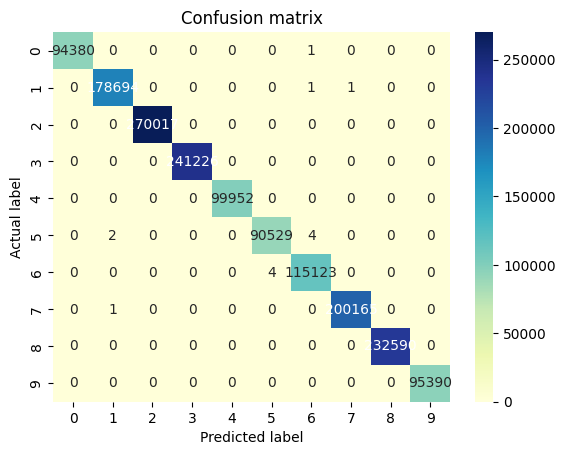

In [77]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap ='YlGnBu', fmt = 'g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Métricas
accuracy = accuracy_score(y_test, y_pred)
classification_report_results = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # PPR
recall = recall_score(y_test, y_pred, average='weighted')  # TVP
f1 = f1_score(y_test, y_pred, average='weighted')  # F1-Score

# Especificidad (Tasa de Verdaderos Negativos): Hacerlo para cada clase y luego promediar.
specificity_list = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)

specificity_avg = np.mean(specificity_list)  # TVN promedio


In [79]:
print(classification_report_results)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94381
           1       1.00      1.00      1.00    178696
           2       1.00      1.00      1.00    270017
           3       1.00      1.00      1.00    241226
           4       1.00      1.00      1.00     99952
           5       1.00      1.00      1.00     90535
           6       1.00      1.00      1.00    115127
           7       1.00      1.00      1.00    200166
           8       1.00      1.00      1.00    232590
           9       1.00      1.00      1.00     95390

    accuracy                           1.00   1618080
   macro avg       1.00      1.00      1.00   1618080
weighted avg       1.00      1.00      1.00   1618080



In [80]:
accuracy

0.9999913477701968

In [81]:
precision

0.9999913477903772

In [82]:
recall

0.9999913477701968

In [83]:
specificity_avg

0.999999059979209

In [84]:
f1

0.9999913477655915

## Análisis y Conclusiones

- Precisión General: La precisión del modelo en el conjunto de prueba es del 99.99%, lo que indica un rendimiento excepcionalmente alto (Sospechoso). Esto podría sugerir que el modelo está funcionando muy bien, aunque también deberíamos considerar la posibilidad de presentar overfitting, especialmente si la distribución de clases es muy desequilibrada.

- Informe de Clasificación:

    - Para todas de las clases, el modelo logra una precisión y un recall de 1.00, indicando una clasificación perfecta. Lo cuál, muy probablemente, estemos presentando overfitting en el modelo.

Es importante tener en cuenta algunas consideraciones para una próxima iteración del modelo de ML:

- Overfitting: Una precisión casi perfecta en el conjunto de prueba puede ser indicativa de sobreajuste, especialmente si el conjunto de datos de entrenamiento es pequeño o si las clases están muy desbalanceadas.
- Validación Cruzada: Para una evaluación más robusta del modelo, es importante aplicar validación cruzada. Esto implica dividir el conjunto de datos de diferentes maneras y entrenar y evaluar el modelo múltiples veces para asegurar que el rendimiento es consistente.
- Equilibrio de Clases: Si algunas clases están subrepresentadas, el modelo podría tener dificultades para clasificarlas correctamente.

Para reducir el overfitting se podrían aplicar las siguientes estrategias:
1. Número de árboles (n_estimators): Aumentar el número de árboles puede ayudar hasta cierto punto, pero después de cierto número, las mejoras pueden ser marginales y pueden aumentar el costo computacional.
2. Profundidad máxima del árbol (max_depth): Limitar la profundidad de los árboles puede prevenir que el modelo se vuelva demasiado complejo. Se podría empezar con valores bajos e incrementarlos si es necesario.
3. Aplicar un número mínimo de muestras requeridas para dividir un nodo interno (min_samples_split): Aumentar este número puede forzar al modelo a hacer divisiones solo si hay suficientes muestras, lo que puede ayudar a evitar el overfitting.
4. Disminuir la complejidad del modelo: Se considerará usar menos variables explicativas si algunas de ellas no son significativas o podrían estar añadiendo ruido. Por ejemplo, usar únicamente bpm y duracion para analizar estas dos variables. 

Por otro lado, considero importante poder hacer otro tipo de modelos, como de regresión por ejemplo, con el fin de predecir la cantidad de tracks que harán release en cierto periodo de tiempo.